In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('..')
import torch

import params
from lavse.data.loaders import get_loader
from lavse.model import model
from lavse.train.train import Trainer
from lavse.utils import file_utils, helper
from lavse.utils.logger import create_logger
from run import load_yaml_opts, parse_loader_name
from tqdm import tqdm
from lavse.data.collate_fns import Collate
from lavse.utils import layers
import json
from PIL import Image
import numpy as np
from lavse.train.evaluation import predict_loader

import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rc('font', family='fonts-japanese-mincho')
# matplotlib.rc('font', family='Arial')
# matplotlib.rcParams['font.fantasy'] = 'Ubuntu'
from torchvision import transforms
collate = Collate('liwe')

In [28]:
from matplotlib import font_manager as fm, rcParams
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='/home/douglas/Osaka.ttf', size=14)
rcParams['font.family'] = fp.get_name()

In [3]:
model_path = '../logs/jap_precomp.jt/liwe-adamax/best_model.pkl'
opt = load_yaml_opts('../logs/jap_precomp.jt/liwe-adamax/options.yaml')

In [4]:
ngpu = 1
loaders = []

if 'DATA_PATH' not in os.environ:
    data_path = '/opt/jonatas/datasets/lavse'
#     data_path = '../lavse'
#     data_path = opt.dataset.data_path
else:
    data_path = os.environ['DATA_PATH']


print(opt.dataset.lang)
opt.dataset.vocab_paths = ['../{}'.format(p) for p in opt.dataset.vocab_paths]
for data_name in opt.dataset.val.data:
    data_name, lang = parse_loader_name(data_name)
    print(data_name)
    loader = get_loader(
        data_split='test',
        data_path=data_path,
        data_name=data_name,
        loader_name=opt.dataset.loader_name,
        local_rank=0,
        lang=lang,
        text_repr=opt.dataset.text_repr,
        vocab_paths=opt.dataset.vocab_paths,
        ngpu=ngpu,
        **opt.dataset.val,
    )
    loaders.append(loader)

device = torch.device('cuda:0')

print(len(loaders))
loader = loaders[0]
tokenizers = loader.dataset.tokenizers
if type(tokenizers) != list:
    tokenizers = [tokenizers]

{}
jap_precomp
Image div 5
1


In [5]:
# load model and options
model = model.LAVSE(**opt.model, tokenizers=tokenizers)#.to(device)
checkpoint = helper.restore_checkpoint(
    path=model_path,
    model=model,
)

model.set_devices_(
    txt_devices=[device],
    img_devices=[device],
    loss_device=device,
)
is_master = True
model.master = is_master # FIXME: Replace "if print" by built_in print


In [6]:
img_embs, cap_embs, cap_lens = predict_loader(model, loader, device)
print(img_embs.shape, cap_embs.shape)
# img_embs /= np.linalg.norm(img_embs, axis=1, keepdims=True)
# cap_embs /= np.linalg.norm(cap_embs, axis=1, keepdims=True)
print(img_embs.shape, cap_embs.shape)

(977, 1024) (4885, 1024)
(977, 1024) (4885, 1024)


In [7]:
ids = np.load('/opt/jonatas/datasets/lavse/jap_precomp/test_ids.npy')
new_ids = np.zeros((len(ids)*5), dtype=np.int64)
for i in range(len(ids)):
    new_ids[i*5:(i*5)+5] = ids[i]
    
loader.dataset.ids = new_ids
print(ids.min(), ids.max(), ids.mean())

jp_caps = np.loadtxt('/opt/jonatas/datasets/lavse/jap_precomp/test_caps.jp.txt', delimiter='@', dtype='unicode')

1589 581770 295001.5353121801


In [8]:
# with open('/opt/jonatas/datasets/lavse/f30k/dataset_flickr30k.json', 'r') as fp:
#     flickr = json.load(fp)
#     f30k = {x['filename']: x for x in flickr['images']}
with open('/opt/jonatas/datasets/lavse/jap_precomp/yjcaptions26k/yjcaptions26k_clean.json', 'r') as fp:
    flickr = json.load(fp)

In [9]:
new_info = {x['id']: x for x in flickr['images']}

flickr['images'][0]


{'license': 4,
 'file_name': 'COCO_train2014_000000000030.jpg',
 'coco_url': 'http://mscoco.org/images/30',
 'height': 428,
 'width': 640,
 'date_captured': '2013-11-24 03:32:32',
 'flickr_url': 'http://farm4.staticflickr.com/3377/3573516590_a1f6cf2cbd_z.jpg',
 'id': 30}

In [10]:
flickr['images'][0]

{'license': 4,
 'file_name': 'COCO_train2014_000000000030.jpg',
 'coco_url': 'http://mscoco.org/images/30',
 'height': 428,
 'width': 640,
 'date_captured': '2013-11-24 03:32:32',
 'flickr_url': 'http://farm4.staticflickr.com/3377/3573516590_a1f6cf2cbd_z.jpg',
 'id': 30}

In [11]:
img_embs, cap_embs, cap_lens = torch.tensor(img_embs), torch.tensor(cap_embs), torch.tensor(cap_lens)
sims = model.get_sim_matrix_shared(
        embed_a=img_embs, embed_b=cap_embs,
        lens=cap_lens, shared_size=128
    )
sims = layers.tensor_to_numpy(sims)
print(sims.shape)
new_sims = np.zeros((4885, 4885))
for i in range(977):
    new_sims[i*5:(i*5)+5] = sims[i]
sims = new_sims
print(sims.shape)

(977, 4885)
(4885, 4885)


In [12]:
print(sims.min(), sims.max(), sims.mean())
print(type(sims))

-0.31286752223968506 0.7506911158561707 0.001237300415810233
<class 'numpy.ndarray'>


In [13]:
len(flickr['images'])

26500

# TEXT2IMAGE

sim1k (4885, 977)
ピ ザ を 手 に し た 男 性 が 親 指 を 立 て て 笑 顔 を 見 せ て い ま す 。


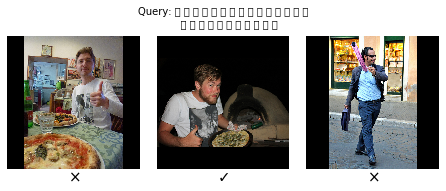

In [29]:
# text 2 img
lang = 'jp'
sims_t = sims.T
sims_t1k = sims_t[:, range(0, sims_t.shape[1], 5)]
print('sim1k', sims_t1k.shape)
inds = np.argsort(sims_t1k, axis=1)[:, ::-1]

ld = loader

cap_idx = 51

for cap_idx in np.random.choice(4885, 100, replace=False):
#     cap = ld.dataset.captions[cap_idx]
    cap = jp_caps[cap_idx]
    print(cap)

    n = 15
    if cap.endswith('.'):
        cap = cap[:-2]
    split_str = cap.split(' ')
    if len(split_str) > n:
        for j in range(n, len(split_str), n):
            split_str[j-1] += '\n   '
    cap = ' '.join(split_str)
    cap = '{}: {}'.format('Query', cap)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.gca().set_axis_off()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.axis('off')
    plt.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=0, hspace=0)


    ax.set_axis_off()
    fig.add_axes(ax)

    imgs = []
    preds = []
    for i in range(0, 3):
        img_idx = inds[cap_idx, i] * 5
        pred = cap_idx in range(img_idx, img_idx + 5)
        preds.append(pred)

        # restore original indexes
        img_id = int(ld.dataset.ids[img_idx])
        img_info = new_info[img_id]
#         img_info = flickr['images'][img_id]
        img_set = img_info['file_name'].split('_')[1]
        img = Image.open(os.path.join('/opt/jonatas/datasets/lavse/coco/images', img_set, img_info['file_name']))
        crop = transforms.CenterCrop(max(img.size))
        img = crop(img).resize((400,400))
        img = np.asarray(img)
        if i < 2:
            img = np.pad(img, [[0,0], [0,50], [0,0]], mode='constant', constant_values=255)
        imgs.append(img)

    imgs = np.hstack(imgs)
    ax.imshow(imgs)
    plt.text(imgs.shape[1]/2., -30, cap, fontsize=10, horizontalalignment='center')
    first = 200
    for i in range(3):
        symb = '$\checkmark$' if preds[i] else '$\\times$'
        plt.text(first, img.shape[0] + 35, symb, fontsize=15, horizontalalignment='center')
        first += 450
#     plt.savefig('/home/douglas/retrieval_imgs/t2i/{}/t2i_{}_{}.pdf'.format(lang, lang, cap_idx), bbox_inches='tight', dpi=166, pad_inches=0)
    plt.show()
    plt.close()
    break

# old code below

---------------------------

In [15]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['/usr/share/fonts/truetype/msttcorefonts/arialbi.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/Georgia_Bold.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/verdanai.ttf',
 '/usr/share/fonts/truetype/lato/Lato-Hairline.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-C.ttf',
 '/usr/share/fonts/truetype/liberation2/LiberationSans-Bold.ttf',
 '/usr/share/fonts/truetype/Nakula/nakula.ttf',
 '/usr/share/fonts/truetype/liberation2/LiberationSans-Italic.ttf',
 '/usr/share/fonts/truetype/kacst/KacstPoster.ttf',
 '/usr/share/fonts/truetype/tlwg/TlwgTypist-Oblique.ttf',
 '/usr/share/fonts/truetype/malayalam/AnjaliOldLipi.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf',
 '/usr/share/fonts/truetype/padauk/Padauk-Regular.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/Arial_Black.ttf',
 '/usr/share/fonts/truetype/ttf-bitstream-vera/VeraMoBI.ttf',
 '/usr/share/fonts/truetype/lato/Lato-BoldItalic.ttf',
 '/usr/share/fonts/truetype/tlwg/Laksaman-Bold.ttf',
 '/usr/share/fonts/truetype/openoffic

In [ ]:
# success cases
lang = loader.dataset.lang
print('sim matrix shape', sims.shape)
inds = np.argsort(sims, axis=1)[:, ::-1]
print('inds shape', inds.shape)
from matplotlib.transforms import Bbox

max_length = 60
ld = loader
for k in np.random.choice(np.arange(5, 5000, 5), 100, replace=False):#range(5, 5000, 5):
    img_ix = k
    img_id = int(ld.dataset.ids[img_ix])
#     print 'img id', img_id
    img_info = flickr['images'][img_id]
    img = Image.open(os.path.join('/opt/jonatas/datasets/lavse/f30k/images/flickr30k_images', img_info['filename']))
    crop = transforms.CenterCrop(max(img.size))
    img = crop(img).resize((400,400))

    fig = plt.figure(figsize=(4, 4))
#     fig.patch.set_visible(False)
    ax = fig.add_subplot(111)
    plt.axis('off')
    plt.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=0, hspace=0)
    
    
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img)
    gt = range(img_ix, img_ix + 5)

    preds = []
    caps = []
    for i in range(5):
        pred = inds[img_ix, i] in gt
        preds.append(pred)
        caps.append(ld.dataset.captions[inds[img_ix, i]])

    n = 8
    big_str = []
    biggest_cap = 0
    for i in range(5):
        cap = caps[i]
        if cap.endswith('.'):
            cap = cap[:-2]
        split_str = cap.split(' ')
        if len(split_str) > n:
            for j in range(n, len(split_str), n):
                split_str[j-1] += '\n   '
        split_str = ' '.join(split_str)
        symb = '$\checkmark$' if preds[i] else '$\\times$'
        br = ''
        if i < 4:
            br = '\n\n'
        
        new_cap = ''.join(split_str) + '.'
        
            
        big_str.append('{}. {} {}{}'.format((i+1), new_cap, symb, br))
    text = ''.join(big_str)
    ax.text(img.width + 30, img.height/2, text, verticalalignment='center', fontsize=15)
    
#     if all(preds):
#         print("all corect found :)")
    plt.savefig('/home/douglas/retrieval_imgs/i2t/random/{}/t2i_{}_{}.pdf'.format(lang, lang, img_ix), bbox_inches=Bbox([[0,0],[10,4]]), dpi=166, pad_inches=0)
    if k % 500 == 0:
        print('processed {} images'.format(k/5))
#     plt.show()
    plt.close()
#     break


In [ ]:
# failure cases

print 'sim matrix shape', sims.shape
inds = np.argsort(sims, axis=1)[:, ::-1]
print 'inds shape', inds.shape
from matplotlib.transforms import Bbox

max_length = 60

ld = loader_de

img_ix = 815
img_id = int(ld.dataset.ids[img_ix])
img_info = flickr['images'][img_id]
img = Image.open(os.path.join('/opt/datasets/flickr/flickr30k_images', img_info['filename']))
crop = transforms.CenterCrop(max(img.size))
img = crop(img).resize((400,400))

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
plt.axis('off')
plt.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=0, hspace=0)


ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(img)
gt = range(img_ix, img_ix + 5)

preds = []
caps = []
for i in range(5):
    pred = inds[img_ix, i] in gt
    preds.append(pred)
    caps.append(ld.dataset.captions[inds[img_ix, i]])

n = 7
big_str = []
biggest_cap = 0
for i in range(5):
    cap = caps[i]
    print cap
    if cap.endswith('.'):
        cap = cap[:-2]
    split_str = cap.split(' ')
    if len(split_str) > n:
        for j in range(n, len(split_str), n):
            split_str[j-1] += '\n   '
    split_str = ' '.join(split_str)
    symb = '$\checkmark$' if preds[i] else '$\\times$'
    br = ''
    if i < 4:
        br = '\n\n'

    new_cap = ''.join(split_str) + '.'
    big_str.append('{}. {} {}{}'.format((i+1), new_cap, symb, br))

ax.text(img.width + 30, img.height/2, unicode(''.join(big_str), 'utf-8'), verticalalignment='center', fontsize=15)

plt.savefig('incorrect_predictions/i2t_de_{}_err.pdf'.format(img_ix), bbox_inches=Bbox([[0,0],[10,4]]), dpi=166, pad_inches=0)
plt.show()
plt.close()


In [ ]:
# text 2 img

sims_t = sims.T
sims_t1k = sims_t[:, range(0, sims_t.shape[1], 5)]
print 'sim1k', sims_t1k.shape
inds = np.argsort(sims_t1k, axis=1)[:, ::-1]

ld = loader_de

cap_idx = 3100
cap = ld.dataset.captions[cap_idx]
print cap

n = 10
if cap.endswith('.'):
    cap = cap[:-2]
split_str = cap.split(' ')
if len(split_str) > n:
    for j in range(n, len(split_str), n):
        split_str[j-1] += '\n   '
cap = ' '.join(split_str)
cap = '{}: {}'.format('Query', cap)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.gca().set_axis_off()
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.axis('off')
plt.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=0, hspace=0)


ax.set_axis_off()
fig.add_axes(ax)

imgs = []
preds = []
for i in range(0, 3):
    img_idx = inds[cap_idx, i] * 5
    pred = cap_idx in range(img_idx, img_idx + 5)
    preds.append(pred)
    
    # restore original indexes
    img_id = int(ld.dataset.ids[img_idx])
    img_info = flickr['images'][img_id]
    img = Image.open(os.path.join('/opt/datasets/flickr/flickr30k_images', img_info['filename']))
    crop = transforms.CenterCrop(max(img.size))
    img = crop(img).resize((400,400))
    img = np.asarray(img)
    if i < 2:
        img = np.pad(img, [[0,0], [0,50], [0,0]], mode='constant', constant_values=255)
    imgs.append(img)
        
imgs = np.hstack(imgs)
ax.imshow(imgs)
plt.text(imgs.shape[1]/2., -30, unicode(cap, 'utf-8'), fontsize=10, horizontalalignment='center')
first = 200
for i in range(3):
    symb = '$\checkmark$' if preds[i] else '$\\times$'
    plt.text(first, img.shape[0] + 35, symb, fontsize=15, horizontalalignment='center')
    first += 450
plt.savefig('t2i_imgs/t2i_de_{}.pdf'.format(cap_idx), bbox_inches='tight', dpi=166, pad_inches=0)
plt.show()
